# Homework 5 solutions

We want to take the FFT of our finite-amplitude pendulum and see if the power is associated with the pendulum's period (as we would expect).

Let's start by copying in the code we wrote that integrates the pendulum.  We'll just keep the velocity-Verlet and RK4 integrators.

Just for fun I included more terms in the power-series expansion of the period.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class SimplePendulum:
    """ manage and integrate a simple pendulum """

    def __init__(self, theta0, g=9.81, L=9.81):
        """we'll take theta0 in degrees and assume that the angular
        velocity is initially 0"""
        
        # initial condition
        self.theta0 = np.radians(theta0)

        self.g = g
        self.L = L

    def period(self):
        """ return an estimate of the period, up to the theta**8 term """
        return (2.0 * np.pi * np.sqrt(self.L / self.g) *
                (1.0 + self.theta0**2 / 16.0 +
                 11.0 * self.theta0**4 / 3072.0 +
                 173.0 * self.theta0**6 / 737280) +
                 22931.0 * self.theta0**8 / 1321205760)

    def rhs(self, theta, omega):
        """ equations of motion for a pendulum
              dtheta/dt = omega
              domega/dt = - (g/L) sin theta """

        return np.array([omega, -(self.g / self.L) * np.sin(theta)])

    def integrate_vv(self, dt, tmax):
        """integrate the equations of motion using velocity Verlet method"""

        # initial conditions
        t = 0.0

        t_s = [t]
        theta_s = [self.theta0]
        omega_s = [0.0]

        while t < tmax:

            dt = min(dt, tmax-t)
            
            # initial state
            theta = theta_s[-1]
            omega = omega_s[-1]
            
            thetadot, omegadot = self.rhs(theta, omega)
            omega_half = omega + 0.5 * dt * omegadot                
            theta_new = theta + dt * omega_half

            # get the RHS with the updated theta -- omega doesn't matter
            # here
            _, omegadot_new = self.rhs(theta_new, omega)
            omega_new = omega_half + 0.5 * dt * omegadot_new

            t += dt

            # store
            t_s.append(t)
            theta_s.append(theta_new)
            omega_s.append(omega_new)

        return np.array(t_s), np.array(theta_s), np.array(omega_s)

    def integrate_rk4(self, dt, tmax):
        """integrate the equations of motion using 4th order Runge Kutta"""

        # initial conditions
        t = 0.0

        t_s = [t]
        theta_s = [self.theta0]
        omega_s = [0.0]

        while t < tmax:

            dt = min(dt, tmax-t)
            
            # initial state
            theta = theta_s[-1]
            omega = omega_s[-1]
            
            # get the RHS at time-level n
            thetadot1, omegadot1 = self.rhs(theta, omega)

            theta_tmp = theta + 0.5 * dt * thetadot1
            omega_tmp = omega + 0.5 * dt * omegadot1

            thetadot2, omegadot2 = self.rhs(theta_tmp, omega_tmp)

            theta_tmp = theta + 0.5 * dt * thetadot2
            omega_tmp = omega + 0.5 * dt * omegadot2

            thetadot3, omegadot3 = self.rhs(theta_tmp, omega_tmp)

            theta_tmp = theta + dt * thetadot3
            omega_tmp = omega + dt * omegadot3

            thetadot4, omegadot4 = self.rhs(theta_tmp, omega_tmp)

            theta_new = theta + dt / 6.0 * (thetadot1 + 2.0 * thetadot2 +
                                            2.0 * thetadot3 + thetadot4)
            omega_new = omega + dt / 6.0 * (omegadot1 + 2.0 * omegadot2 +
                                            2.0 * omegadot3 + omegadot4)

            t += dt

            # store
            t_s.append(t)
            theta_s.append(theta_new)
            omega_s.append(omega_new)

        return np.array(t_s), np.array(theta_s), np.array(omega_s)

## RK4, one period

Let's start by doing a single period.  We'll pick a relatively large timestep, $\tau$ (30 points per period).

In [3]:
theta0 = 100
p = SimplePendulum(theta0)

In [4]:
period = p.period()
tmax = period
dt = period/30
t, theta, _ = p.integrate_rk4(dt, tmax)

Now we'll take the FFT---we'll use NumPy's FFT, but you can use the DFT from class.  Notice that as discussed in class, we scale the frequency returned by `rfftfreq` by $\tau$ to make it have physical units.

In [5]:
N = len(theta)
theta_k = np.fft.rfft(theta)
sample_rate = tmax / N
nu = np.fft.rfftfreq(N, d=sample_rate)
nu_true = 1.0 / period

Text(0, 0.5, 'power')

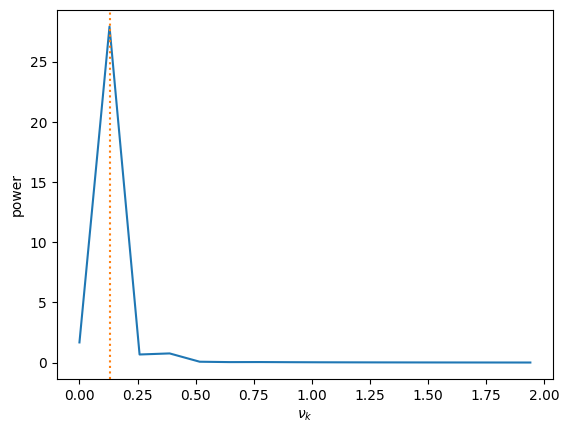

In [6]:
fig, ax = plt.subplots()
ax.plot(nu, np.abs(theta_k))
ax.axvline(x=nu_true, color="C1", ls=":")
ax.set_xlabel(r"$\nu_k$")
ax.set_ylabel("power")

The orange dotted line is the expected period.  We see that we get most of the power there, as expected.

## RK4, 10 periods

Now we'll do 10 periods with the same timestep.

In [7]:
theta0 = 100
p = SimplePendulum(theta0)

In [8]:
period = p.period()
tmax = 10*period
dt = period/30
t, theta, _ = p.integrate_rk4(dt, tmax)

In [9]:
N = len(theta)
theta_k = np.fft.rfft(theta)
sample_rate = tmax / N
nu = np.fft.rfftfreq(N, d=sample_rate)
nu_true = 1.0 / period

Text(0, 0.5, 'power')

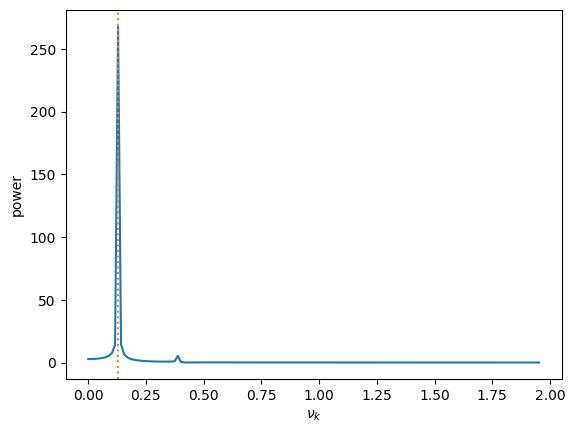

In [10]:
fig, ax = plt.subplots()
ax.plot(nu, np.abs(theta_k))
ax.axvline(x=nu_true, color="C1", ls=":")
#ax.set_xlim(0, 0.5)
ax.set_xlabel(r"$\nu_k$")
ax.set_ylabel("power")

## velocity-Verlet, 10 periods

Now we'll switch to velocity-Verlet to see if there is much difference.

In [11]:
theta0 = 100
p = SimplePendulum(theta0)

In [12]:
period = p.period()
tmax = 10*period
dt = period/30
t, theta, _ = p.integrate_vv(dt, tmax)

Here's what the pendulum's angle looks like

Text(0, 0.5, '$\\theta$')

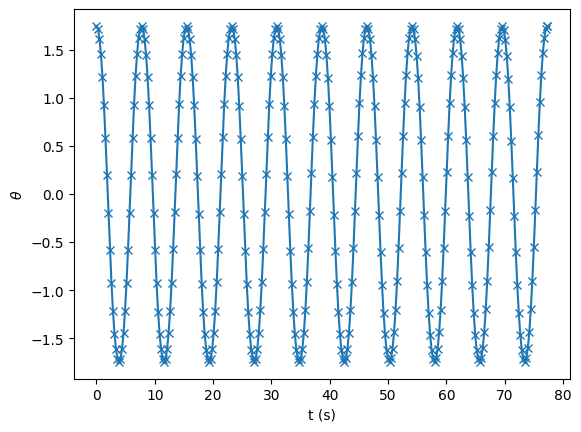

In [13]:
fig, ax = plt.subplots()
ax.plot(t, theta, marker="x")
ax.set_xlabel("t (s)")
ax.set_ylabel(r"$\theta$")

and the FFT

In [14]:
N = len(theta)
theta_k = np.fft.rfft(theta)
sample_rate = tmax / N
nu = np.fft.rfftfreq(N, d=sample_rate)
nu_true = 1.0 / period

Text(0, 0.5, 'power')

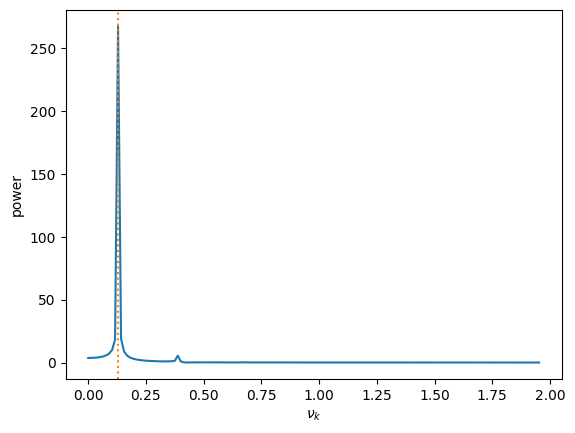

In [15]:
fig, ax = plt.subplots()
ax.plot(nu, np.abs(theta_k))
ax.axvline(x=nu_true, color="C1", ls=":")
ax.set_xlabel(r"$\nu_k$")
ax.set_ylabel("power")

The looks pretty much the same as the RK4 solution.

## Finer timestep, $\tau$

Now let's rerun this with a finer timestep ($10\times$ smaller).

In [16]:
theta0 = 100
p = SimplePendulum(theta0)
period = p.period()
tmax = 10*period
dt = period/300
t, theta, _ = p.integrate_vv(dt, tmax)

Text(0, 0.5, '$\\theta$')

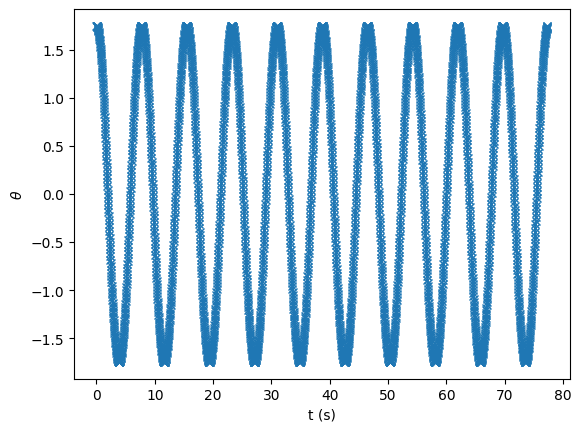

In [17]:
fig, ax = plt.subplots()
ax.plot(t, theta, marker="x")
ax.set_xlabel("t (s)")
ax.set_ylabel(r"$\theta$")

In [18]:
N = len(theta)
theta_k = np.fft.rfft(theta)
sample_rate = tmax / N
nu = np.fft.rfftfreq(N, d=sample_rate)
nu_true = 1.0 / period

Text(0, 0.5, 'power')

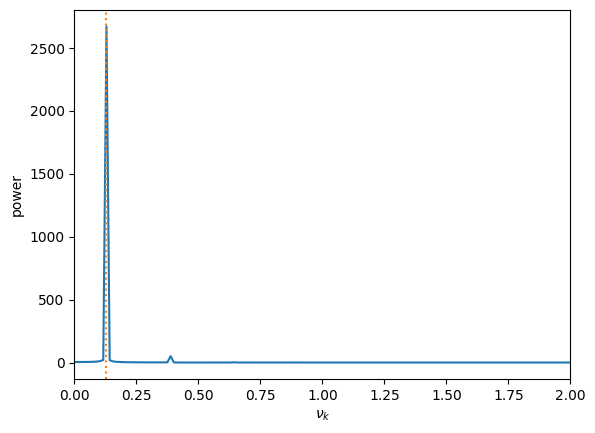

In [19]:
fig, ax = plt.subplots()
ax.plot(nu, np.abs(theta_k))
ax.axvline(x=nu_true, color="C1", ls=":")
ax.set_xlim(0, 2)
ax.set_xlabel(r"$\nu_k$")
ax.set_ylabel("power")

The result looks pretty much the same, although the peak is much sharper.